In [1]:
import glob
import torch
import os.path as op
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

In [2]:
def load_results(result_paths):
    lbs = masks = None
    preds_list = list()
    variances_list = list()

    for test_result_path in result_paths:
        results = torch.load(test_result_path)

        if lbs is not None:
            assert (lbs == results['lbs']).all()
        else:
            lbs: np.ndarray = results['lbs']

        if masks is not None:
            assert (masks == results['masks']).all()
        else:
            masks: np.ndarray = results['masks']

        preds_list.append(results['preds']['preds'])
        try:
            variances_list.append(results['preds']['vars'])
        except KeyError:
            pass

    # aggregate mean and variance
    preds = np.stack(preds_list).mean(axis=0)
    if variances_list:  # regression
        # variances = np.mean(np.stack(preds_list) ** 2 + np.stack(variances_list), axis=0) - preds ** 2
        variances = np.stack(variances_list).mean(axis=0)
    else:
        variances = None

    return preds, variances, lbs, masks


In [19]:
def get_top_k_ids(array, k):
    ind = np.argpartition(array, -k)[-k:]
    ind[np.argsort(array[ind])]
    return ind

In [141]:
data_name = 'qm8'
model_name = 'Uni-Mol'
n_subsample = 100
# n_subsample = 0
sgld_result_dir = f'../output/{data_name}/{model_name}/SGLD/seed-0/preds/'
none_result_dir = f'../output/{data_name}/{model_name}/none/seed-0/preds/'

In [142]:
sgld_result_paths = glob.glob(op.join(sgld_result_dir, "*"))
none_result_paths = glob.glob(op.join(none_result_dir, "*"))

In [146]:
sgld_preds, sgld_variances, lbs, masks = load_results(sgld_result_paths)
none_preds, none_variances, lbs, masks = load_results(none_result_paths)
sgld_preds = sgld_preds.reshape(-1)
sgld_variances = sgld_variances.reshape(-1)
none_preds = none_preds.reshape(-1)
none_variances = none_variances.reshape(-1)
lbs = lbs.reshape(-1)

if n_subsample > 0:
    sampled_ids = np.random.choice(len(lbs), n_subsample)
    sgld_preds = sgld_preds[sampled_ids]
    sgld_variances = sgld_variances[sampled_ids]
    none_preds = none_preds[sampled_ids]
    none_variances = none_variances[sampled_ids]
    lbs = lbs[sampled_ids]


In [147]:
sgld_abs_error = np.abs(sgld_preds - lbs)
none_abs_error = np.abs(none_preds - lbs)
# error_sorted_ids = np.argsort(squared_error)
# sorted_errs = squared_error[error_sorted_ids]
# sorted_vars = sgld_variances[error_sorted_ids]

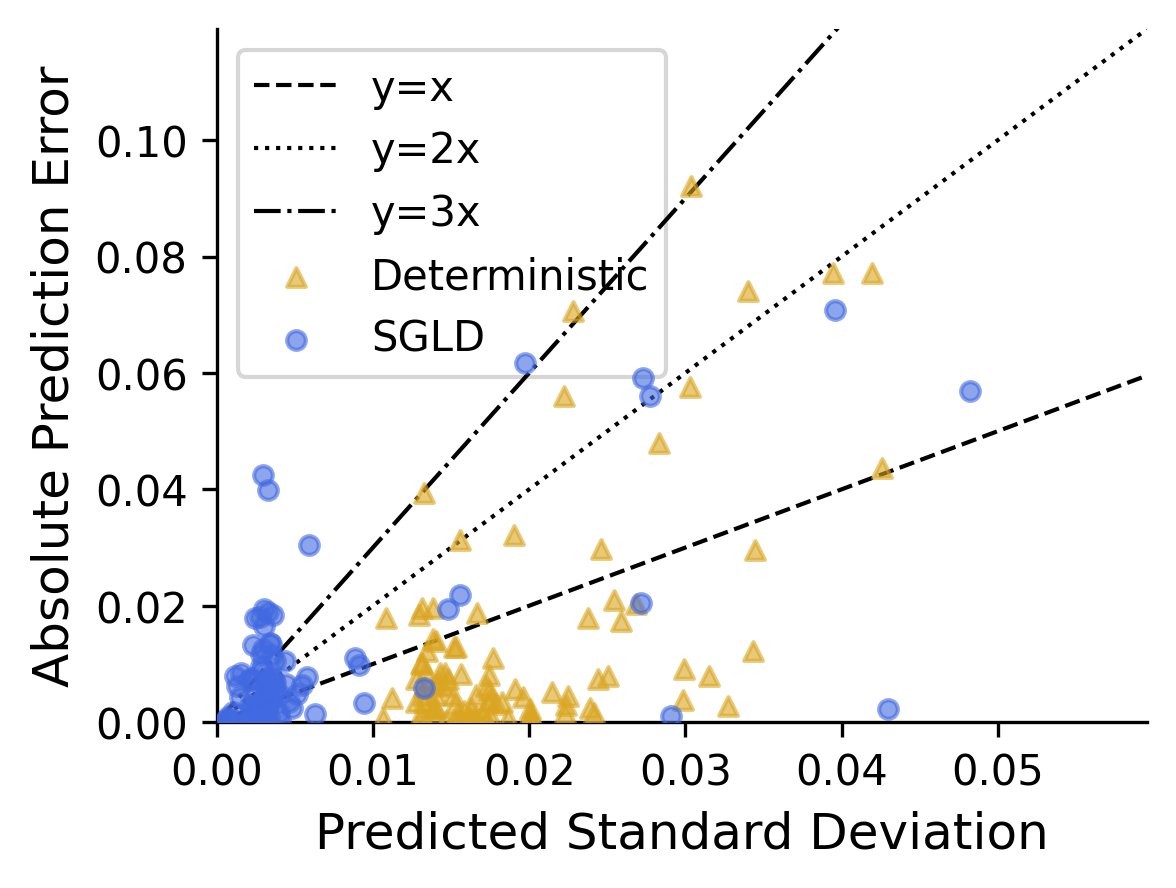

In [148]:
fig, ax = plt.subplots(figsize=(4,3), dpi=300)

ref_x = np.linspace(min(sgld_abs_error.min(), none_abs_error.min()), max(sgld_abs_error.max(), none_abs_error.max()), 100)

ax.plot(ref_x, ref_x, color='black', linestyle="dashed", alpha=1, linewidth=1, zorder=10, label="y=x")
ax.plot(ref_x, ref_x*2, color='black', linestyle="dotted", alpha=1, linewidth=1, zorder=10, label="y=2x")
ax.plot(ref_x, ref_x*3, color='black', linestyle="dashdot", alpha=1, linewidth=1, zorder=10, label="y=3x")
# ax.plot(x1, y1, color='goldenrod', alpha=0.6, linewidth=3, zorder=10)
ax.scatter(np.sqrt(sgld_variances), sgld_abs_error, color='goldenrod', marker='^', s=20, alpha=0.6, zorder=100, label="Deterministic")
# ax.plot(x, y, color='royalblue', alpha=0.6, linewidth=3, zorder=10)
ax.scatter(np.sqrt(none_variances), none_abs_error, color='royalblue', s=20, alpha=0.6, zorder=100, label="SGLD")

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_ylabel('Absolute Prediction Error', fontsize=12)
ax.set_xlabel('Predicted Standard Deviation', fontsize=12)
ax.set_xlim(0, ref_x[-1]/3)
ax.set_ylim(0, ref_x[-1]/1.5)
plt.legend()

f_name = f's5.sgld.dev.{model_name}.{data_name}.png'
fig.savefig(f_name, bbox_inches='tight')